### Загрузка и обработка данных

In [1]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('breast_cancer_dataset.csv', index_col='S/N')
df.head()

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
S/N,,,,,,,,,,
1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
5,2019,21,1,1,0,Right,0,Upper outer,1,Benign


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 213 entries, 1 to 213
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Year              213 non-null    object
 1   Age               213 non-null    int64 
 2   Menopause         213 non-null    int64 
 3   Tumor Size (cm)   213 non-null    object
 4   Inv-Nodes         213 non-null    object
 5   Breast            213 non-null    object
 6   Metastasis        213 non-null    object
 7   Breast Quadrant   213 non-null    object
 8   History           213 non-null    object
 9   Diagnosis Result  213 non-null    object
dtypes: int64(2), object(8)
memory usage: 18.3+ KB


Пропуски в колонках заполнены знаком "#", заменим их на None и посмотрим на отсутствующие данные

In [4]:
df.Year.unique()

array(['2019', '#', '2020'], dtype=object)

In [5]:
df.replace("#", None, inplace=True)

In [6]:
df[df.isnull().any(axis=1)]

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
S/N,,,,,,,,,,
31,2019,56,0,9,1,Left,1,None,0,Malignant
41,None,34,1,None,None,None,None,None,None,Malignant
48,2019,25,1,5,0,None,0,Upper outer,0,Malignant
68,2019,40,1,1,0,Left,0,Lower outer,None,Benign
144,2020,29,1,2,0,None,0,Lower inner,1,Benign
165,2020,38,1,2,0,None,0,Upper outer,1,Benign
167,2020,62,0,3,1,None,1,Upper inner,1,Malignant
179,2020,49,1,4,0,None,0,Lower outer,0,Benign


Заметим, что для пациента под номером 41 пропущена большая часть данных. Уберём из датасета данные пацинета 41. Оставшиеся пропуски заполним методом 'bfill' для столбца "Year", а остальные пропуски заполним модой

In [7]:
df = df.drop(41, axis=0)
df

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
S/N,,,,,,,,,,
1,2019,40,1,2,0,Right,0,Upper inner,0,Benign
2,2019,39,1,2,0,Left,0,Upper outer,0,Benign
3,2019,45,0,4,0,Left,0,Lower outer,0,Benign
4,2019,26,1,3,0,Left,0,Lower inner,1,Benign
5,2019,21,1,1,0,Right,0,Upper outer,1,Benign
...,...,...,...,...,...,...,...,...,...,...
209,2020,49,1,6,3,Right,1,Lower inner,1,Malignant
210,2020,28,1,3,0,Left,0,Upper inner,0,Benign
211,2020,22,1,1,0,Left,0,Upper outer,1,Benign


In [8]:
df[df.isnull().any(axis = 1)]

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Breast,Metastasis,Breast Quadrant,History,Diagnosis Result
S/N,,,,,,,,,,
31,2019,56,0,9,1,Left,1,None,0,Malignant
48,2019,25,1,5,0,None,0,Upper outer,0,Malignant
68,2019,40,1,1,0,Left,0,Lower outer,None,Benign
144,2020,29,1,2,0,None,0,Lower inner,1,Benign
165,2020,38,1,2,0,None,0,Upper outer,1,Benign
167,2020,62,0,3,1,None,1,Upper inner,1,Malignant
179,2020,49,1,4,0,None,0,Lower outer,0,Benign


In [9]:
df.Year = df.Year.fillna(method='bfill')

In [10]:
for col in df.columns:
    most_common_value = df[col].mode()[0]
    df[col].fillna(most_common_value, inplace=True)

In [11]:
df.duplicated().sum()

0

In [12]:
df.isna().sum()

Year                0
Age                 0
Menopause           0
Tumor Size (cm)     0
Inv-Nodes           0
Breast              0
Metastasis          0
Breast Quadrant     0
History             0
Diagnosis Result    0
dtype: int64

Дубликатов и пропусков нет! Поменяем типы данных у числовых колонок, так как сейчас большинство столбцов имеет тип object

In [13]:
num_cols = ['Age', 'Menopause', 'Year', 'Tumor Size (cm)', 'Inv-Nodes', 'Metastasis', 'History']

In [14]:
df[num_cols] = df[num_cols].astype(np.int16)

In [15]:
df.describe()

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Metastasis,History
count,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000,212.000000
mean,2019.523585,39.811321,0.665094,4.268868,0.353774,0.344340,0.410377
std,0.500626,14.124439,0.473075,2.571881,0.508072,0.476277,0.493066
min,2019.000000,13.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2019.000000,30.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,2020.000000,40.000000,1.000000,4.000000,0.000000,0.000000,0.000000
75%,2020.000000,49.250000,1.000000,6.000000,1.000000,1.000000,1.000000
max,2020.000000,77.000000,1.000000,14.000000,3.000000,1.000000,1.000000


In [16]:
df.describe(include=object)

,Breast,Breast Quadrant,Diagnosis Result
count,212,212,212
unique,2,5,2
top,Left,Upper outer,Benign
freq,112,68,120


Мы видим, что есть неточность в признаке `Breast Quadrant`. Нужно исправить!

In [17]:
obj_cols = ['Breast', 'Breast Quadrant']

In [18]:
df['Breast Quadrant'].unique()

array(['Upper inner', 'Upper outer', 'Lower outer', 'Lower inner',
       'Upper outer '], dtype=object)

In [19]:
df.replace("Upper outer ", "Upper outer", inplace=True)

### Подготовка данных и обучение моделей

In [20]:
processed_data = df.copy()

In [21]:
X = df.drop('Diagnosis Result', axis=1)
y = df['Diagnosis Result']

In [22]:
X = pd.get_dummies(X, columns=obj_cols, drop_first=True)
X

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Metastasis,History,Breast_Right,Breast Quadrant_Lower outer,Breast Quadrant_Upper inner,Breast Quadrant_Upper outer
S/N,,,,,,,,,,,
1,2019,40,1,2,0,0,0,True,False,True,False
2,2019,39,1,2,0,0,0,False,False,False,True
3,2019,45,0,4,0,0,0,False,True,False,False
4,2019,26,1,3,0,0,1,False,False,False,False
5,2019,21,1,1,0,0,1,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
209,2020,49,1,6,3,1,1,True,False,False,False
210,2020,28,1,3,0,0,0,False,False,True,False
211,2020,22,1,1,0,0,1,False,False,False,True


In [23]:
y = y.replace(['Benign', 'Malignant'], [1, 0])
y

S/N
1      1
2      1
3      1
4      1
5      1
      ..
209    0
210    1
211    1
212    1
213    1
Name: Diagnosis Result, Length: 212, dtype: int64

In [24]:
X = X.replace([True, False], [1, 0])
X

,Year,Age,Menopause,Tumor Size (cm),Inv-Nodes,Metastasis,History,Breast_Right,Breast Quadrant_Lower outer,Breast Quadrant_Upper inner,Breast Quadrant_Upper outer
S/N,,,,,,,,,,,
1,2019,40,1,2,0,0,0,1,0,1,0
2,2019,39,1,2,0,0,0,0,0,0,1
3,2019,45,0,4,0,0,0,0,1,0,0
4,2019,26,1,3,0,0,1,0,0,0,0
5,2019,21,1,1,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
209,2020,49,1,6,3,1,1,1,0,0,0
210,2020,28,1,3,0,0,0,0,0,1,0
211,2020,22,1,1,0,0,1,0,0,0,1


Посмотрим на корреляции признаков

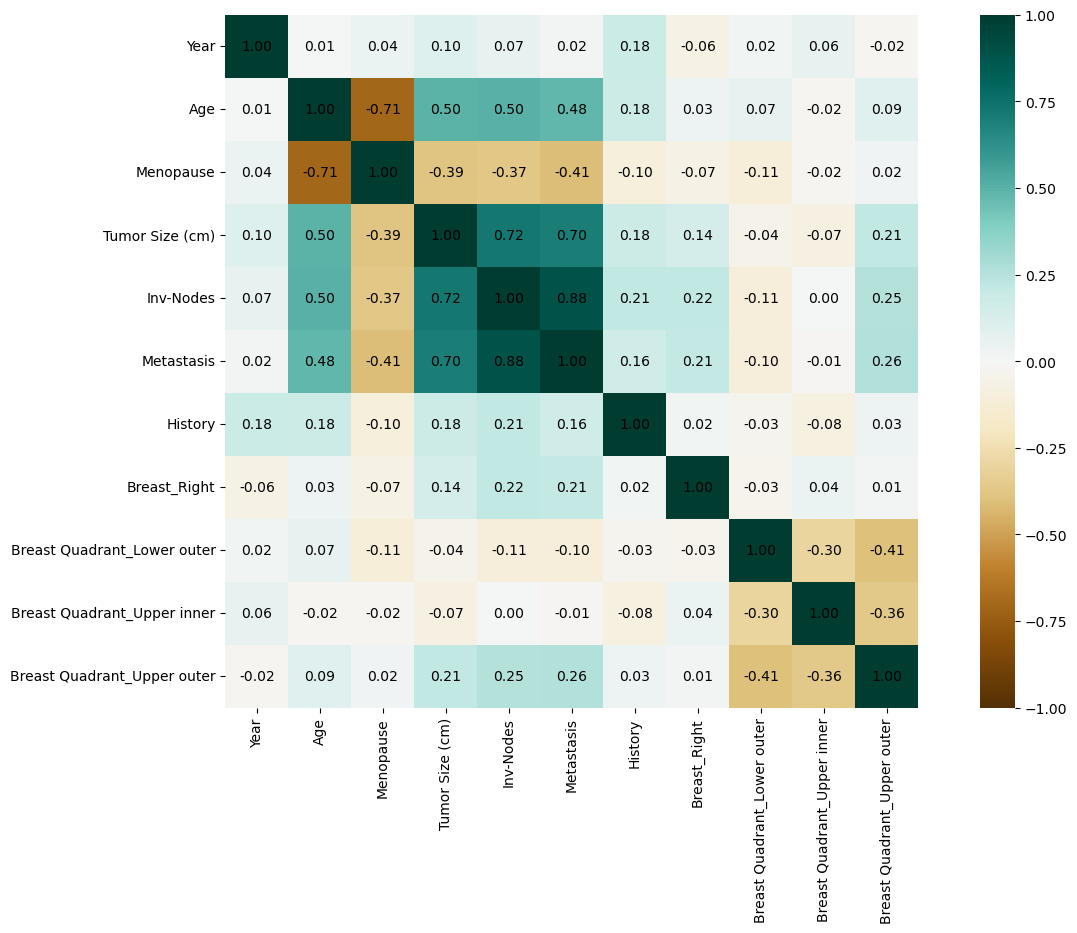

In [25]:
plt.figure(figsize=(16, 9))

sns.heatmap(X.corr(),
            cmap='BrBG',
            vmin=-1,
            vmax=1,
            square=True,
            fmt='.2g')

# Добавляем аннотации вручную
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        plt.text(j+0.5, i+0.5, '{:.2f}'.format(X.corr().iloc[i, j]), ha='center', va='center', color='black')

plt.show()

In [26]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[num_cols], 5))

Top Absolute Correlations
Inv-Nodes        Metastasis    0.884761
Tumor Size (cm)  Inv-Nodes     0.724791
Age              Menopause     0.708850
Tumor Size (cm)  Metastasis    0.697875
Age              Inv-Nodes     0.502680
dtype: float64


Видно, что `Inv-Nodes` сильнее всего коррелирует с остальными признаками. В дальнейшем посмотрим, как избавление от этого признака скажется на точности моделей.\
Обучим логистическую регрессию

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=1)

In [28]:
lr = LogisticRegression(random_state=1)
lr.fit(X_train, y_train)
print(f"Train accuracy of Logistic Regression: {round(accuracy_score(y_train, lr.predict(X_train)), 3)}",
      f"Test accuracy of Logistic Regression: {round(accuracy_score(y_test, lr.predict(X_test)), 3)}",
      f"Train f1_score of Logistic Regression: {round(f1_score(y_train, lr.predict(X_train)), 3)}",
      f"Test f1_score of Logistic Regression: {round(f1_score(y_test, lr.predict(X_test)), 3)}", sep='\n')

Train accuracy of Logistic Regression: 0.905
Test accuracy of Logistic Regression: 0.891
Train f1_score of Logistic Regression: 0.917
Test f1_score of Logistic Regression: 0.916


In [29]:
lr = Pipeline([("scaler", StandardScaler()),
               ("LR", LogisticRegression(random_state=1))])
lr.fit(X_train, y_train)
print(f"Train accuracy of Logistic Regression: {round(accuracy_score(y_train, lr.predict(X_train)), 3)}",
      f"Test accuracy of Logistic Regression: {round(accuracy_score(y_test, lr.predict(X_test)), 3)}",
      f"Train f1_score of Logistic Regression: {round(f1_score(y_train, lr.predict(X_train)), 3)}",
      f"Test f1_score of Logistic Regression: {round(f1_score(y_test, lr.predict(X_test)), 3)}", sep='\n')

Train accuracy of Logistic Regression: 0.919
Test accuracy of Logistic Regression: 0.906
Train f1_score of Logistic Regression: 0.929
Test f1_score of Logistic Regression: 0.927


In [30]:
lr = Pipeline([("scaler", StandardScaler()),
               ("LR", LogisticRegression(random_state=1))])
lr.fit(X_train.drop('Inv-Nodes', axis=1), y_train)
print(f"Train accuracy of Logistic Regression: {round(accuracy_score(y_train, lr.predict(X_train.drop('Inv-Nodes', axis=1))), 3)}",
      f"Test accuracy of Logistic Regression: {round(accuracy_score(y_test, lr.predict(X_test.drop('Inv-Nodes', axis=1))), 3)}",
      f"Train f1_score of Logistic Regression: {round(f1_score(y_train, lr.predict(X_train.drop('Inv-Nodes', axis=1))), 3)}",
      f"Test f1_score of Logistic Regression: {round(f1_score(y_test, lr.predict(X_test.drop('Inv-Nodes', axis=1))), 3)}", sep='\n')

Train accuracy of Logistic Regression: 0.919
Test accuracy of Logistic Regression: 0.875
Train f1_score of Logistic Regression: 0.929
Test f1_score of Logistic Regression: 0.902


Оставим признак `Inv-Nodes`, так как его удаление негативно сказывается на нашей модели.\
Обучим также другие модели на наших данных

In [31]:
lr = Pipeline([("scaler", StandardScaler()),
               ("LR", LogisticRegression(random_state=1))])

sv = Pipeline([("scaler", StandardScaler()),
               ("SV", SVC(random_state=1))])

dt = Pipeline([("scaler", StandardScaler()),
               ("DT", DecisionTreeClassifier(random_state=1))])

rf = Pipeline([("scaler", StandardScaler()),
               ("RF", RandomForestClassifier(random_state=1))])

xgb = Pipeline([("scaler", StandardScaler()),
                ("XGB", XGBClassifier(random_state=1))])

cb = Pipeline([("scaler", StandardScaler()),
               ("CB", CatBoostClassifier(random_state=1, silent=True))])

In [32]:
models_list = [lr, sv, dt, rf, xgb, cb]

In [33]:
accuracy_train = {}
accuracy_test = {}
f1_train = {}
f1_test = {}

for model in models_list:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    accuracy_train[model.steps[1][0]] = round(accuracy_score(y_train, y_pred_train), 3)
    accuracy_test[model.steps[1][0]] = round(accuracy_score(y_test, y_pred_test), 3)
    f1_train[model.steps[1][0]] = round(f1_score(y_train, y_pred_train), 3)
    f1_test[model.steps[1][0]] = round(f1_score(y_test, y_pred_test), 3)
    print(f'{model.steps[1][0]} finished')

LR finished
SV finished
DT finished
RF finished
XGB finished
CB finished


In [34]:
metric_df = pd.DataFrame(
    {'accuracy_train': accuracy_train, 'accuracy_test': accuracy_test, 'f1_train': f1_train, 'f1_test': f1_test}
)
metric_df

,accuracy_train,accuracy_test,f1_train,f1_test
LR,0.919,0.906,0.929,0.927
SV,0.926,0.906,0.935,0.930
DT,1.000,0.828,1.000,0.861
RF,1.000,0.859,1.000,0.889
XGB,1.000,0.844,1.000,0.875
CB,0.986,0.891,0.988,0.916


### Вывод
Лучше всего с задачей справились логистическая регрессия и классификация методом опорных векторов.\
Увеличение точности модели можно осуществить подбором наилучших гиперпараметров!